In [1]:
import numpy as np
from scipy.io import loadmat
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
from scipy.stats import ranksums
from scipy.stats import pearsonr
from numpy.random import permutation
import time
import matplotlib.pyplot as plt
import json

In [2]:
# Define font size for plots
FS = 40

In [3]:
# Load pixel lists for groups of PSDs. All pixel lists have already had
# axons that didn't make the applied cuts removed.

# Columns are VAST Segment ID, axon ID, target ID, synapse ID for
# axon-target pair, x nm, y nm, z nm for all data EXCEPT the P7 CF-non-PC1
# PSDs (with the corrected PSDs).  THAT data set has not saved the segment
# IDs, so when working with all the arrays, we will concatenate without the
# segment IDs for consistency.

# Output columns: axon ID, target ID, synapse ID for axon-target pair, area
# in nm^2, 1st latency, 2nd latency, 3rd latency

In [4]:
# P3 PSDs
p3_psd_dict = loadmat('./data/psd_raw_data/P3_PSD_VAST_Seg_IDs_Ax_Targ_and_Syn_IDs_and_px_list_x_y_z_scaled_to_nm.mat') # Variable is PSDpxlist
PSDpxlist = p3_psd_dict['PSDpxlist']
pxlistfinal_P3_0 = PSDpxlist[:,1:7] # upper bound on ID range is non-inclusive, remember

In [5]:
# P7 PSDs
p7_psd_dict1 = loadmat('./data/psd_raw_data/P7_PSD_CF_PC1_VAST_Seg_IDs_Ax_Targ_and_Syn_IDs_and_px_list_x_y_z_scaled_to_nm.mat') # CF-PC1 synapses. Variable is PSDpxlist
PSDpxlist = p7_psd_dict1['PSDpxlist']
pxlistfinal_P7_1 = PSDpxlist[:,1:7]

p7_psd_dict2 = loadmat('./data/psd_raw_data/P7_PSD_CF_Non-PC1_Ind_Fixes_VAST_Seg_IDs_Ax_Targ_and_Syn_IDs_and_px_list_x_y_z_scaled_to_nm.mat') # CF-non-PC1 synapses, fixes only. Variable is PSDpxlist
PSDpxlist = p7_psd_dict2['PSDpxlist']
pxlistfinal_P7_2 = PSDpxlist[:,1:7]

p7_psd_dict3 = loadmat('./data/psd_raw_data/P7_PSDs_CF_Non_PC1_Synapses_ONLY_Correct_Annotations_Px_List_um_w_Axon_and_Targ_IDs.mat') #CF-non-PC1 synapses minus CFs that needed correction (added above). Variable is pxlist
pxlistfinal_P7_3 = p7_psd_dict3['pxlist']

p7_psd_dict4 = loadmat('./data/psd_raw_data/P7_PSD_CF_PC1_from_PC1_Ax_Ext_VAST_Seg_IDs_Ax_Targ_and_Syn_IDs_and_px_list_x_y_z_scaled_to_nm.mat') # CF-PC1 synapses from axonal extension. Variable is PSDpxlist
PSDpxlist = p7_psd_dict4['PSDpxlist']
pxlistfinal_P7_4 = PSDpxlist[:,1:7]

p7_psd_dict5 = loadmat('./data/psd_raw_data/P7_PSD_CF_Non-PC1_from_PC1_Ax_Ext_VAST_Seg_IDs_Ax_Targ_and_Syn_IDs_and_px_list_x_y_z_scaled_to_nm.mat') # CF-Non-PC1 synapses from axonal extension. Variable is PSDpxlist
PSDpxlist = p7_psd_dict5['PSDpxlist']
pxlistfinal_P7_5 = PSDpxlist[:,1:7]

pxlistfinal_P7_0 = np.append(pxlistfinal_P7_1,pxlistfinal_P7_2,axis=0)
pxlistfinal_P7_0 = np.append(pxlistfinal_P7_0,pxlistfinal_P7_3,axis=0)
pxlistfinal_P7_0 = np.append(pxlistfinal_P7_0,pxlistfinal_P7_4,axis=0)
pxlistfinal_P7_0 = np.append(pxlistfinal_P7_0,pxlistfinal_P7_5,axis=0)

In [6]:
# Process the pixel list to remove all axons to cut

# Load axon IDs for P3 connectivity matrix
# From
# 'F:\P3_and_P7_Analysis_Scripts_Backup_MATLAB\181227_analysis_conn-based_ax_cuts\getP3synsinfofromspreadsheet_FD_conn_based_ax_cuts.m'
# File
# 'F:\P3_and_P7_Analysis_Scripts_Backup_MATLAB\181227_analysis_conn-based_ax_cuts\connectivity_matrices\P3_axon_IDs_for_Obs_PC_Conn_Syn_Nums_gteq_5_syns_gteq_40pc_PC_syns.mat'
# Variable is 'P3_PCconn_axon_IDs'
p3a_dict = loadmat('./data/connectivity_matrices/P3_axon_IDs_for_Obs_PC_Conn_Syn_Nums_gteq_5_syns_gteq_40pc_PC_syns.mat')
P3_PCconn_axon_IDs = p3a_dict['P3_PCconn_axon_IDs']

# Load axon IDs for P7 connectivity matrix
# From
# 'F:\P3_and_P7_Analysis_Scripts_Backup_MATLAB\181227_analysis_conn-based_ax_cuts\getP7synsinfofrommatfile_FD_conn_based_ax_cuts.m'
# File
# 'F:\P3_and_P7_Analysis_Scripts_Backup_MATLAB\181227_analysis_conn-based_ax_cuts\connectivity_matrices\P7_axon_IDs_for_Obs_PC_Conn_Syn_Nums_gteq_5_syns_gteq_70pc_PC_syns.mat'
# Variable is 'P7_PCconn_axon_IDs'
p7a_dict = loadmat('./data/connectivity_matrices/P7_axon_IDs_for_Obs_PC_Conn_Syn_Nums_gteq_5_syns_gteq_70pc_PC_syns.mat')
P7_PCconn_axon_IDs = p7a_dict['P7_PCconn_axon_IDs']

P3_rows_to_remove = [i for i,q in enumerate(pxlistfinal_P3_0[:,0]) if not q in P3_PCconn_axon_IDs]
P7_rows_to_remove = [i for i,q in enumerate(pxlistfinal_P7_0[:,0]) if not q in P7_PCconn_axon_IDs]

pxlistfinal_P3 = np.delete(pxlistfinal_P3_0,P3_rows_to_remove,axis=0)
pxlistfinal_P7 = np.delete(pxlistfinal_P7_0,P7_rows_to_remove,axis=0)

In [7]:
sectionwidth   = 30.0 # In nm (the current units of the pixel coordinates in the lists)

In [8]:
# Debugging:
# # Get a test list to work with
# axcheck = P3_PCconn_axon_IDs[0]
# # pxlistfinal_P3
# print(axcheck)
# rc,cc = np.where(np.expand_dims(pxlistfinal_P3[:,0],axis=1)==axcheck)
# targs = list(set([pxlistfinal_P3[q,1] for q in rc]))
# rt,ct = np.where( (np.expand_dims(pxlistfinal_P3[:,1],axis=1)==targs[0]) )
# rat = list(set(rc).intersection(set(rt)))
# syns = list(set([pxlistfinal_P3[q,2] for q in rat]))
# rs,cs = np.where( (np.expand_dims(pxlistfinal_P3[:,2],axis=1)==syns[0]) )
# rats = list(set(rat).intersection(set(rs)))
# print(rats)
# test_pxlist = pxlistfinal_P3[rats,:]
# print(test_pxlist.shape)

Define a function to compute the areas of convex hulls once they are calculated for each PSD (the built-in area property of the convex hull function used here seems to produce incorrect results).

In [9]:
# Use this function instead to compute areas since something seems to be going strangely for the convex hull
# area calculation
# (from https://stackoverflow.com/questions/19873596/convex-hull-area-in-python)
def PolyArea2D(pts):
    lines = np.hstack([pts,np.roll(pts,-1,axis=0)])
    area = 0.5*abs(sum(x1*y2-x2*y1 for x1,y1,x2,y2 in lines))
    return area

Define the function that performs the projection of pixel lists onto the plane formed by the first two PCA components and then computes the convex hull. This code was originally stored in the MATLAB file ./181227_analysis_conn-based_ax_cuts/twodconvhullcalc.m

In [10]:
def twodconvhullcalc(pxlist,sectionthickness):
    # @pxlist: This is an N-by-6 array, with each row cooresponding to a pixel belonging to a pixel list for a PSD.
    # All pixels for all PSDs are included in this array. Columns are axon ID, target ID, synapse ID for axon-target
    # pair, x, y, and z.

    # @sectionthickness: The width of the section in the same units as the pixel coordinates.  Will use this value
    # to thicken the PSDs so a single section has width.

    # @idsandareas: A dictionary with one entry per PSD represented in pxlist.
    # Fields are axon ID, target ID, synapse ID for axon-target pair, area (of convex hull of 2D projection
    # of PSD voxel list, in units of the input pixel coordinates squared)
    # The last three entries are the first, second, and third latencies from the PCA calculation for each PSD.

    # Process the pixel list for each PSD
    axs = []
    targs = []
    psds = []
    areas = []
    l1s = []
    l2s = []
    l3s = []

    unique_axon_list  = list(set(pxlist[:,0].tolist()))

    for axcurr in unique_axon_list:
        axcurrrows    = [i for i,q in enumerate(pxlist[:,0]) if q == axcurr]
        targsax       = [pxlist[q,1] for q in axcurrrows]
        uniquetargsax = list(set(targsax))

        for targcurr in uniquetargsax:
            targcurrrows      = [i for i,q in enumerate(pxlist[:,1]) if q == targcurr]
            axtargcurrrows    = list(set(axcurrrows).intersection(set(targcurrrows)))
            synsaxtarg        = [pxlist[q,2] for q in axtargcurrrows]
            uniquesynsaxtarg  = list(set(synsaxtarg)) # NOTE: synapse IDs are not always of the form [1:nsyns]

            for PSDcurr in uniquesynsaxtarg:
                PSDcurrrows = [i for i,q in enumerate(pxlist[:,2]) if q == PSDcurr]
                PSDcurrrows = list(set(axtargcurrrows).intersection(set(PSDcurrrows)))
                PSDcurrpxlist = np.asarray([pxlist[q,3:6] for q in PSDcurrrows])

                # Remove voxel dust (produced sometimes when PSDs were annotated with shared segment IDs, because
                # they were then distinguished using connected components)
                # Dust: segments with fewer than 3 voxels
                if (PSDcurrpxlist.shape[0] > 2):
                    # Translate the pixel list so the origin is at the center of mass
                    # (standardize data points: done by default in PCA but also needed for projections)
                    comx = np.tile( np.mean(PSDcurrpxlist[:,0]) , (PSDcurrpxlist.shape[0],1) )
                    comy = np.tile( np.mean(PSDcurrpxlist[:,1]) , (PSDcurrpxlist.shape[0],1) )
                    comz = np.tile( np.mean(PSDcurrpxlist[:,2]) , (PSDcurrpxlist.shape[0],1) )
                    com = np.append(comx,comy,axis=1)
                    com = np.append(com,comz,axis=1)
                    PSDcurrpxlist = PSDcurrpxlist - com

                    # Fill voxel list in z based on section thickness so that annotations in a single z-section
                    # do not have zero thickness (to improve the accuracy of PCA)
                    zdim = np.expand_dims(PSDcurrpxlist[:,2],axis=1)
                    halfwidth = np.tile( 0.5*sectionthickness, (zdim.shape[0],zdim.shape[1]) )
                    PSDcurrpxlist_lt_half = np.append(PSDcurrpxlist[:,0:2],(zdim-halfwidth),axis=1)
                    PSDcurrpxlist_gt_half = np.append(PSDcurrpxlist[:,0:2],(zdim+halfwidth),axis=1)
                    PSDcurrpxlist = np.append(PSDcurrpxlist,PSDcurrpxlist_lt_half,axis=0)
                    PSDcurrpxlist = np.append(PSDcurrpxlist,PSDcurrpxlist_gt_half,axis=0)
                    PSDcurrpxlist = PSDcurrpxlist.astype(int)

                    # Perform PCA for the current PCA
                    pca = PCA()
                    pca.fit(PSDcurrpxlist)
                    components = pca.components_ # shape of this array is n_components, n_features
                    
                    # The third component gives the direction in which voxel spatial variance is smallest. In other
                    # words, it gives the normal to an approximation of the plane of the PSD.
                    
                    # project voxels onto the plane normal to the 3rd component vector
                    third_comp_unit_vector = np.tile( components[-1,:] , (PSDcurrpxlist.shape[0],1) )
                    proj_onto_3rd_comp_mag = np.sum(np.multiply(PSDcurrpxlist,third_comp_unit_vector),axis=1)
                    proj_onto_3rd_comp_x = np.expand_dims(np.multiply(proj_onto_3rd_comp_mag,third_comp_unit_vector[:,0]),axis=1)
                    proj_onto_3rd_comp_y = np.expand_dims(np.multiply(proj_onto_3rd_comp_mag,third_comp_unit_vector[:,1]),axis=1)
                    proj_onto_3rd_comp_z = np.expand_dims(np.multiply(proj_onto_3rd_comp_mag,third_comp_unit_vector[:,2]),axis=1)
                    proj_onto_3rd_comp = np.append(proj_onto_3rd_comp_x,proj_onto_3rd_comp_y,axis=1)
                    proj_onto_3rd_comp = np.append(proj_onto_3rd_comp,proj_onto_3rd_comp_z,axis=1)

                    # Compute projection onto the plane orthogonal to the 3rd component vector
                    # by subtracting the projection onto the 3rd component vector from original voxel vectors
                    proj_onto_3rd_comp_norm_plane = PSDcurrpxlist - proj_onto_3rd_comp
                    
                    # Take the projected PSD and rotate it into the x-y plane
                    # Find the polar angle theta between the 3rd component and the z-axis, and subtract that value
                    # from the theta values of all the projected pixels in spherical polar coordinate representation
                    # Then convert the pixels back to Cartesian coordinates and remove the z-coordinate,
                    # which should be zero after this rotation.

                    # Get components of 3rd component unit vector so they are easier to work with for this rotation
                    px   = components[-1,0]
                    py   = components[-1,1]
                    pz   = components[-1,2]
                    prho = np.sqrt(px*px + py*py)
                    
                    # Matrix for a cw rotation of the 3rd component's azimuthal angle about the
                    # positive z-axis, followed by a cw rotation of the polar angle about the positive y-axis
                    if prho != 0:
                        RyRz = [[(px*pz)/prho, (py*pz)/prho, -prho], [-py/prho, px/prho, 0], [px, py, pz]]
                    else: # If prho == 0, the normal vector is already lined up with the z-axis and doesn't need to be rotated
                        #(in fact the rotation matrix above will contain infinite values and fail in this case)
                        RyRz = [[1, 0, 0], [0, 1, 0], [0, 0, 1]] # Rotation is the identity here

                    # Turn projected points into a row of column 3-vectors so the rotation can be applied to all at once
                    projectedvectors = np.transpose(proj_onto_3rd_comp_norm_plane)
                    rotprojectedpts = np.matmul(RyRz,projectedvectors)

                    # Transpose results to get back a pixel list
                    rot3dprojpxlist = np.transpose(rotprojectedpts)

                    # Remove z-coordinate (3rd col), which should now be zero
                    projected_pxlist_2d = rot3dprojpxlist[:,0:2]

                    # Check points list for NaNs or Infs and if you find one
                    # display an error message telling what you found and telling
                    # what the axon, target, and PSD ids are.
                    nanrows,dummycols = np.where(np.isnan(projected_pxlist_2d))
                    infrows,dummycols = np.where(np.isinf(projected_pxlist_2d))

                    if len(nanrows) > 0:
                        print('Found {0} pixels with value NaN for axon ID {1}, targ ID {2}, PSD ID {3}.'.format(length(nanrows),axcurr,targcurr,PSDcurr))
                    if len(infrows) > 0:
                        print('Found {0} pixels with value Inf for axon ID {1}, targ ID {2}, PSD ID {3}.'.format(length(infrows),axcurr,targcurr,PSDcurr))

                    if ((len(nanrows) > 0) or (len(infrows) > 0)):
                        print('Exiting function.')
                        return

                    # Compute the convex hull of the projection and compute its area.
                    hullpts = ConvexHull(projected_pxlist_2d)
                    
                    # Compute the area within the convex hull vertices (nm^2)
                    areacurr = PolyArea2D(projected_pxlist_2d[hullpts.vertices])

#                     return(projected_pxlist_2d[hullpts.vertices],hullpts.area)

#                     areacurr = hullpts.area
                    # Store results
                    latent = pca.explained_variance_ratio_
                    axs.append(axcurr)
                    targs.append(targcurr)
                    psds.append(PSDcurr)
                    areas.append(areacurr)
                    l1s.append(latent[0])
                    l2s.append(latent[1])
                    l3s.append(latent[2])

                else:
                    print('Axon ID {0}, target ID {1}, PSD ID {2} had fewer than 3 pixels in its pixel list. It is being considered dust and was not processed.'.format(axcurr,targcurr,PSDcurr))
    
    idsandareas = {'ax':axs,'targ':targs,'psd':psds,'area':areas,'l1':l1s,'l2':l2s,'l3':l3s}
    return idsandareas

In [11]:
# Process the pixel lists for each PSD one at a time to get an estimate of
# the surface area, in nm^2, for each of the PSDs in each data set.

# P3
print('Processing P3 data...')
start = time.time()
P3_IDs_and_Areas = twodconvhullcalc(pxlistfinal_P3,sectionwidth)
# P3_IDs_and_Areas = twodconvhullcalc(pxlistfinal_P3[rats,:],sectionwidth)
end = time.time()
print('It took {0:.2f} seconds to process the P3 data.'.format(end-start))

# P7
print('Processing P7 data...')
start = time.time()
P7_IDs_and_Areas = twodconvhullcalc(pxlistfinal_P7,sectionwidth)
end = time.time()
print('It took {0} seconds to process the P7 data.'.format(end-start))

Processing P3 data...
It took 60.06 seconds to process the P3 data.
Processing P7 data...
Axon ID 36, target ID 22, PSD ID 5 had fewer than 3 pixels in its pixel list. It is being considered dust and was not processed.
It took 58.038817167282104 seconds to process the P7 data.


Inspect distributions of PSD area for both datasets

In [12]:
PCrows_P3 = [i for i,q in enumerate(P3_IDs_and_Areas['targ']) if q == -999]
PCrows_P7 = [i for i,q in enumerate(P3_IDs_and_Areas['targ']) if q == -999]

In [13]:
# Keep only entries corresponding to Purkinje cell targets
PC_ROWS_ONLY = 1

if PC_ROWS_ONLY:
    PCrows_P3 = [i for i,q in enumerate(P3_IDs_and_Areas['targ']) if q != -999]
    PCrows_P7 = [i for i,q in enumerate(P3_IDs_and_Areas['targ']) if q != -999]

    p3a = [P3_IDs_and_Areas['ax'][q] for q in PCrows_P3]
    p3t = [P3_IDs_and_Areas['targ'][q] for q in PCrows_P3]
    p3p = [P3_IDs_and_Areas['psd'][q] for q in PCrows_P3]
    p3area = [P3_IDs_and_Areas['area'][q] for q in PCrows_P3]
    p3l1 = [P3_IDs_and_Areas['l1'][q] for q in PCrows_P3]
    p3l2 = [P3_IDs_and_Areas['l2'][q] for q in PCrows_P3]
    p3l3 = [P3_IDs_and_Areas['l3'][q] for q in PCrows_P3]
    P3_IDs_and_Areas_PCs = {'ax':p3a,'targ':p3t,'psd':p3p,'area':p3area,'l1':p3l1,'l2':p3l2,'l3':p3l3}
    
    p7a = [P7_IDs_and_Areas['ax'][q] for q in PCrows_P7]
    p7t = [P7_IDs_and_Areas['targ'][q] for q in PCrows_P7]
    p7p = [P7_IDs_and_Areas['psd'][q] for q in PCrows_P7]
    p7area = [P7_IDs_and_Areas['area'][q] for q in PCrows_P7]
    p7l1 = [P7_IDs_and_Areas['l1'][q] for q in PCrows_P7]
    p7l2 = [P7_IDs_and_Areas['l2'][q] for q in PCrows_P7]
    p7l3 = [P7_IDs_and_Areas['l3'][q] for q in PCrows_P7]
    P7_IDs_and_Areas_PCs = {'ax':p7a,'targ':p7t,'psd':p7p,'area':p7area,'l1':p7l1,'l2':p7l2,'l3':p7l3}

In [14]:
# Convert areas to um^2
areas_P3 = [q*1.0e-6 for q in P3_IDs_and_Areas_PCs['area']]
areas_P7 = [q*1.0e-6 for q in P7_IDs_and_Areas_PCs['area']]

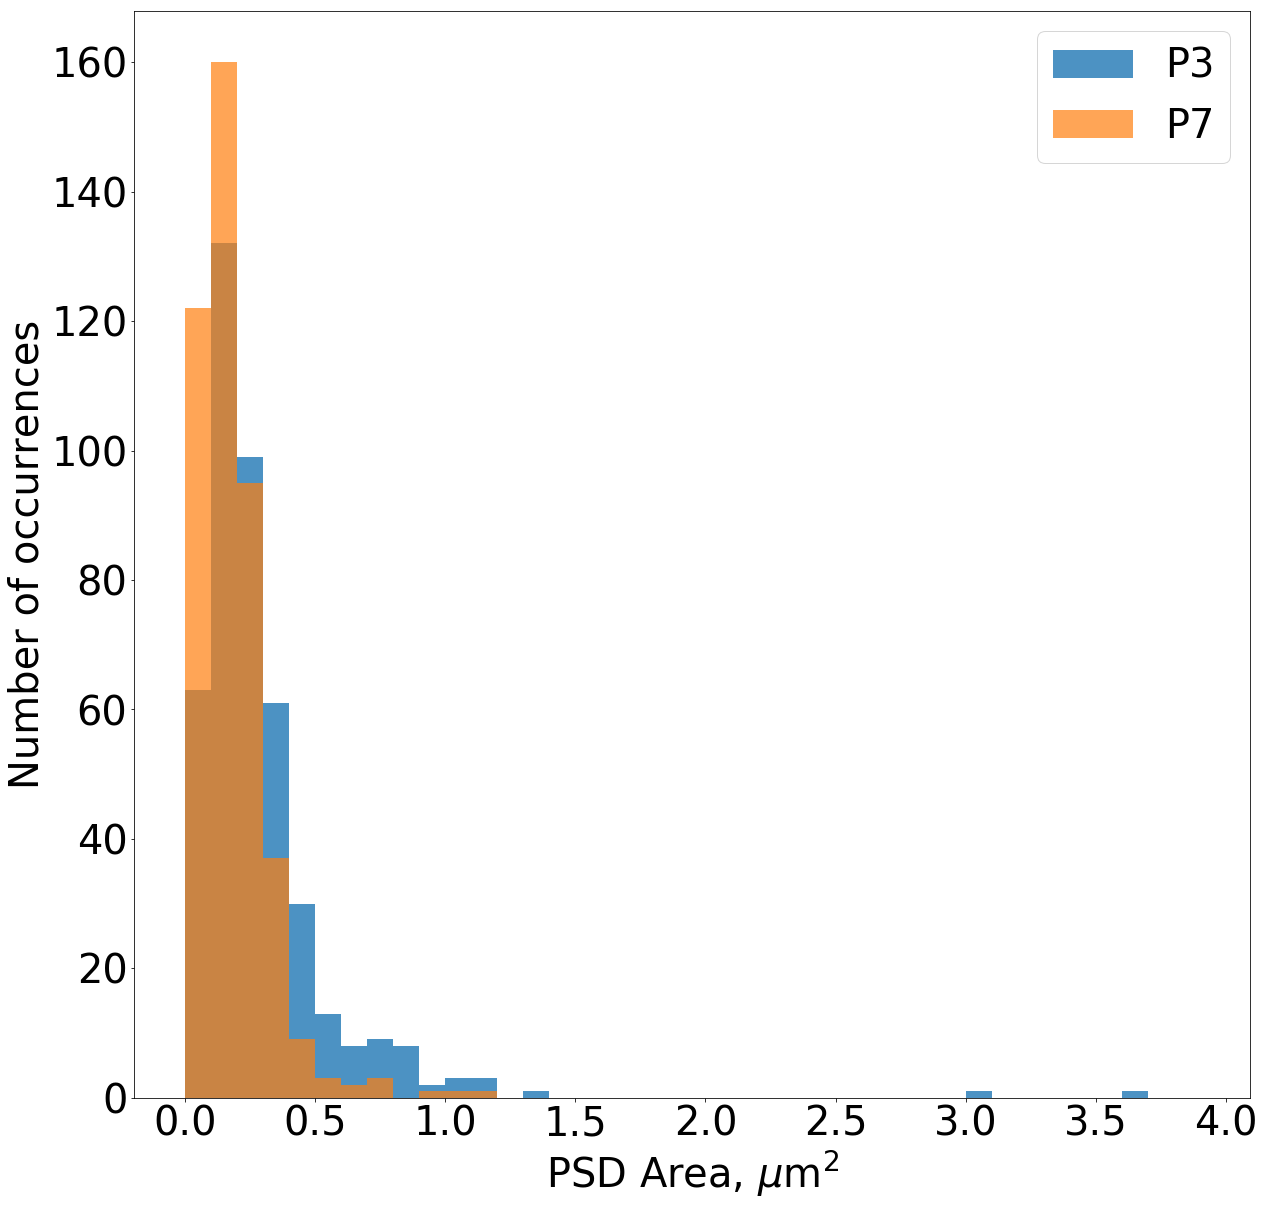

In [15]:
# Plot distributions of PSD areas for P3 and P7
edges_psd_p3_p7_comp = np.arange(0,400,10)*0.01

# # p3
# plt.figure()
# hP3 = plt.hist(areas_P3,bins=edges_psd_p3_p7_comp)
# plt.xlabel('PSD Area, um$^2$',fontsize=FS)
# plt.ylabel('Frequency',fontsize=FS)
# plt.title('P3',fontsize=FS)
# plt.xlim((0,0.02))
# plt.ylim((0,175))
# plt.show()
# # p7
# plt.figure()
# hP7 = plt.hist(areas_P7,bins=edges_psd_p3_p7_comp)
# plt.xlabel('PSD Area, um$^2$',fontsize=FS)
# plt.ylabel('Frequency',fontsize=FS)
# plt.title('P7',fontsize=FS)
# plt.xlim((0,0.02))
# plt.ylim((0,175))
# plt.show()

# p3 and p7
plt.figure(figsize=(20,20))
plt.hist(areas_P3,bins=edges_psd_p3_p7_comp,label='P3',alpha=0.8)
plt.hist(areas_P7,bins=edges_psd_p3_p7_comp,label='P7',alpha=0.7)
plt.xlabel('PSD Area, $\mu$m$^2$',fontsize=FS)
plt.ylabel('Number of occurrences',fontsize=FS)
# plt.title('PSD Area Distributions, P3 vs. P7',fontsize=FS)
plt.legend(loc='best',fontsize=FS)
plt.tick_params(labelsize=FS)
# plt.show()
psdfname = './data/figures/psds/190213_p3_p7_psd_area_dists_um2.png'
plt.savefig(psdfname)

Test whether the p3 and p7 distributions are statistically distinguishable with a Wilcoxon rank sum test

In [16]:
stat,p = ranksums(areas_P3,areas_P7)
print(p)

5.3998835338312535e-15


Plot PSD areas as a function of connection size (i.e. the total number of synapses formed by the presynaptic climbing fiber branch and the postsynaptic Purkinje cell for the current PSD)

In [17]:
# Get the connectivity matrices for both data sets (this is the easiest way to do it)
# p3
p3c_dict = loadmat('./data/connectivity_matrices/P3_Observed_PC_Connectivity_Synapse_Numbers_gteq_5_syns_gteq_40pc_PC_targets.mat')
p3a_dict = loadmat('./data/connectivity_matrices/P3_axon_IDs_for_Obs_PC_Conn_Syn_Nums_gteq_5_syns_gteq_40pc_PC_syns.mat')
p3p_dict = loadmat('./data/connectivity_matrices/P3_PC_IDs_for_Obs_PC_Conn_Syn_Nums_gteq_5_syns_gteq_40pc_PC_syns.mat')
p3c = p3c_dict['P3_PCconnectivity']
p3a = p3a_dict['P3_PCconn_axon_IDs']
p3p = p3p_dict['P3_PCconn_PC_IDs']
# p7
p7c_dict = loadmat('./data/connectivity_matrices/P7_Observed_PC_Connectivity_Synapse_Numbers_gteq_5_syns_gteq_70pc_PC_targets.mat')
p7a_dict = loadmat('./data/connectivity_matrices/P7_axon_IDs_for_Obs_PC_Conn_Syn_Nums_gteq_5_syns_gteq_70pc_PC_syns.mat')
p7p_dict = loadmat('./data/connectivity_matrices/P7_PC_IDs_for_Obs_PC_Conn_Syn_Nums_gteq_5_syns_gteq_70pc_PC_syns.mat')
p7c = p7c_dict['P7_PCconnectivity']
p7a = p7a_dict['P7_PCconn_axon_IDs']
p7p = p7p_dict['P7_PCconn_PC_IDs']

In [18]:
print(len(P3_IDs_and_Areas['ax']),len(P3_IDs_and_Areas['targ']),len(P3_IDs_and_Areas['psd']),len(P3_IDs_and_Areas['area']))

694 694 694 694


In [19]:
if PC_ROWS_ONLY:
    # p3
    p3_conn_sizes = []
    for idx in range(len(P3_IDs_and_Areas_PCs['ax'])):
        axcurr = P3_IDs_and_Areas_PCs['ax'][idx]
        targcurr = P3_IDs_and_Areas_PCs['targ'][idx]
        rowa,dummy_col = np.where(p3a == axcurr)
        rowp,dummp_col = np.where(p3p == targcurr)
        p3_conn_sizes.append(p3c[rowa,rowp][0])
    # p7
    p7_conn_sizes = []
    for idx in range(len(P7_IDs_and_Areas_PCs['ax'])):
        axcurr = P7_IDs_and_Areas_PCs['ax'][idx]
        targcurr = P7_IDs_and_Areas_PCs['targ'][idx]
        rowa,dummy_col = np.where(p7a == axcurr)
        rowp,dummp_col = np.where(p7p == targcurr)
        p7_conn_sizes.append(p7c[rowa,rowp][0])

Group connection sizes and PSD areas according to their connection size, so that you can plot this data in a box plot if you would like.

In [20]:
p3_sizes_to_process = list(set(p3_conn_sizes))
p3_conn_sz_to_plot = []
p3_psd_areas_per_sz = []
for p3_conn_sz in range(np.max(p3_sizes_to_process)+1):
    p3_conn_sz_to_plot.append(str(p3_conn_sz))
    psd_list = [q for i,q in enumerate(areas_P3) if p3_conn_sizes[i] == p3_conn_sz]
    p3_psd_areas_per_sz.append(psd_list)

p7_sizes_to_process = list(set(p7_conn_sizes))
p7_conn_sz_to_plot = []
p7_psd_areas_per_sz = []
for p7_conn_sz in range(np.max(p7_sizes_to_process)+1):
    if np.remainder(p7_conn_sz,5)==0:
        p7_conn_sz_to_plot.append(str(p7_conn_sz))
    else:
        p7_conn_sz_to_plot.append('')
    psd_list = [q for i,q in enumerate(areas_P7) if p7_conn_sizes[i] == p7_conn_sz]
    p7_psd_areas_per_sz.append(psd_list)

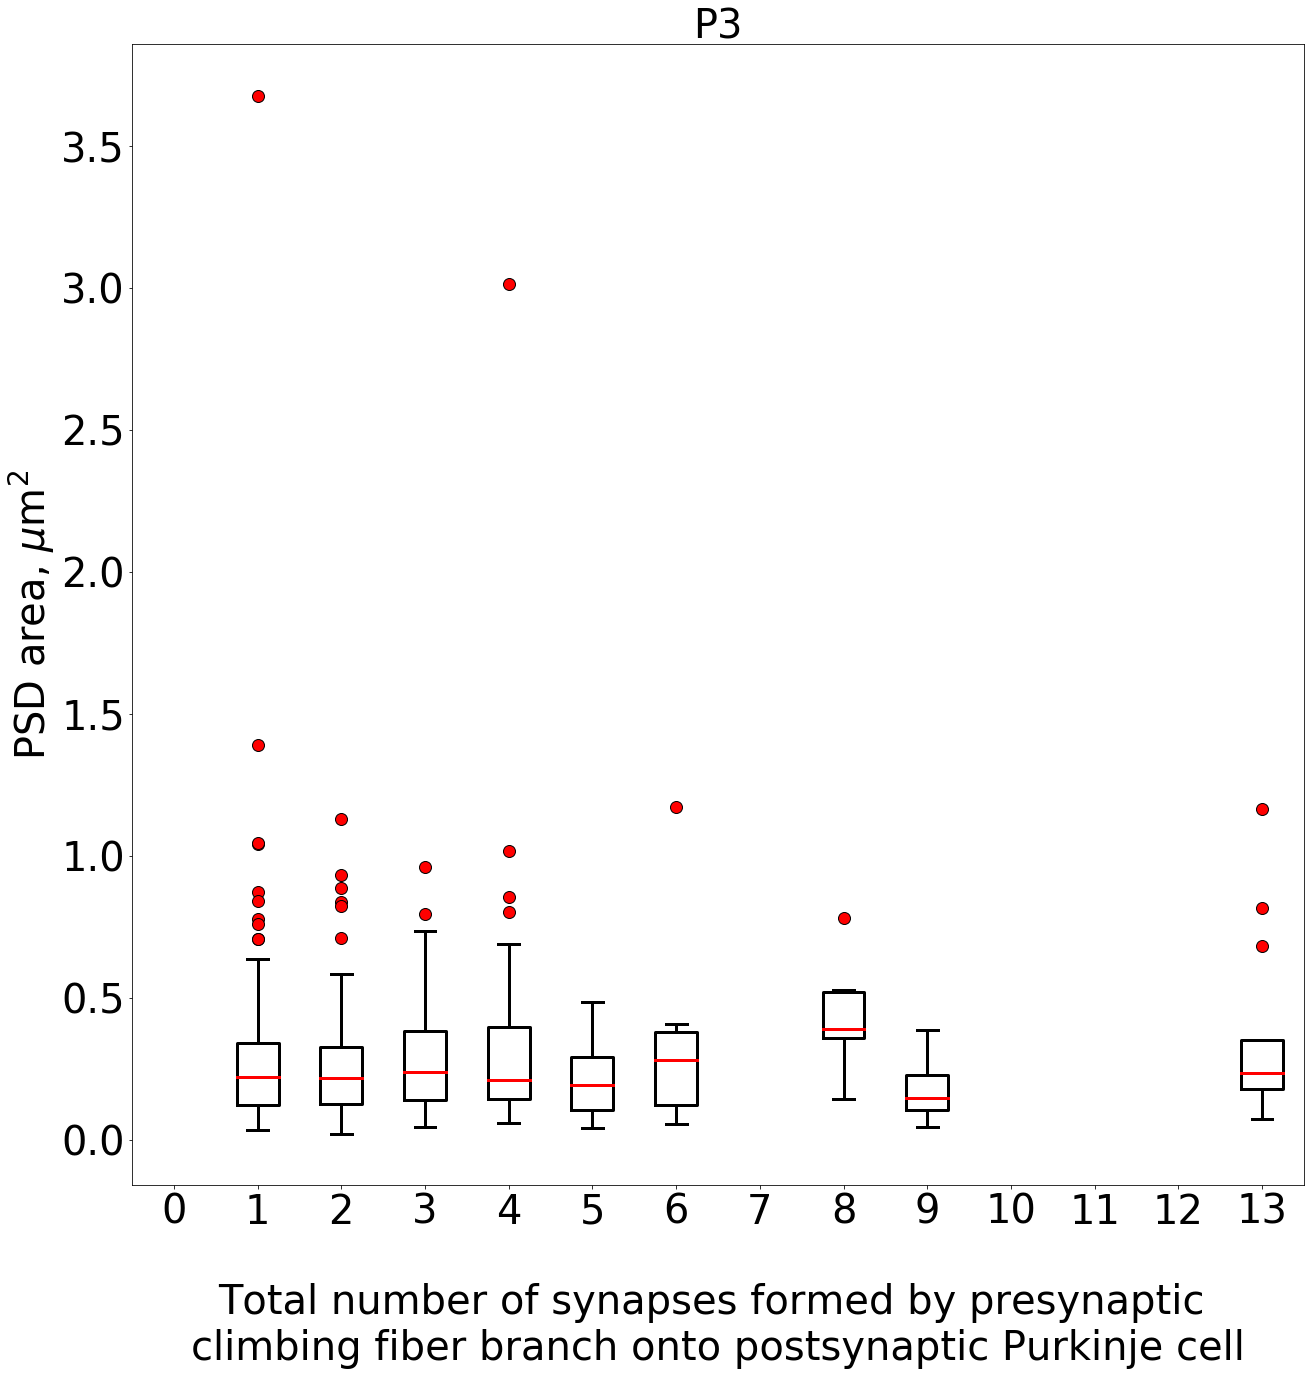

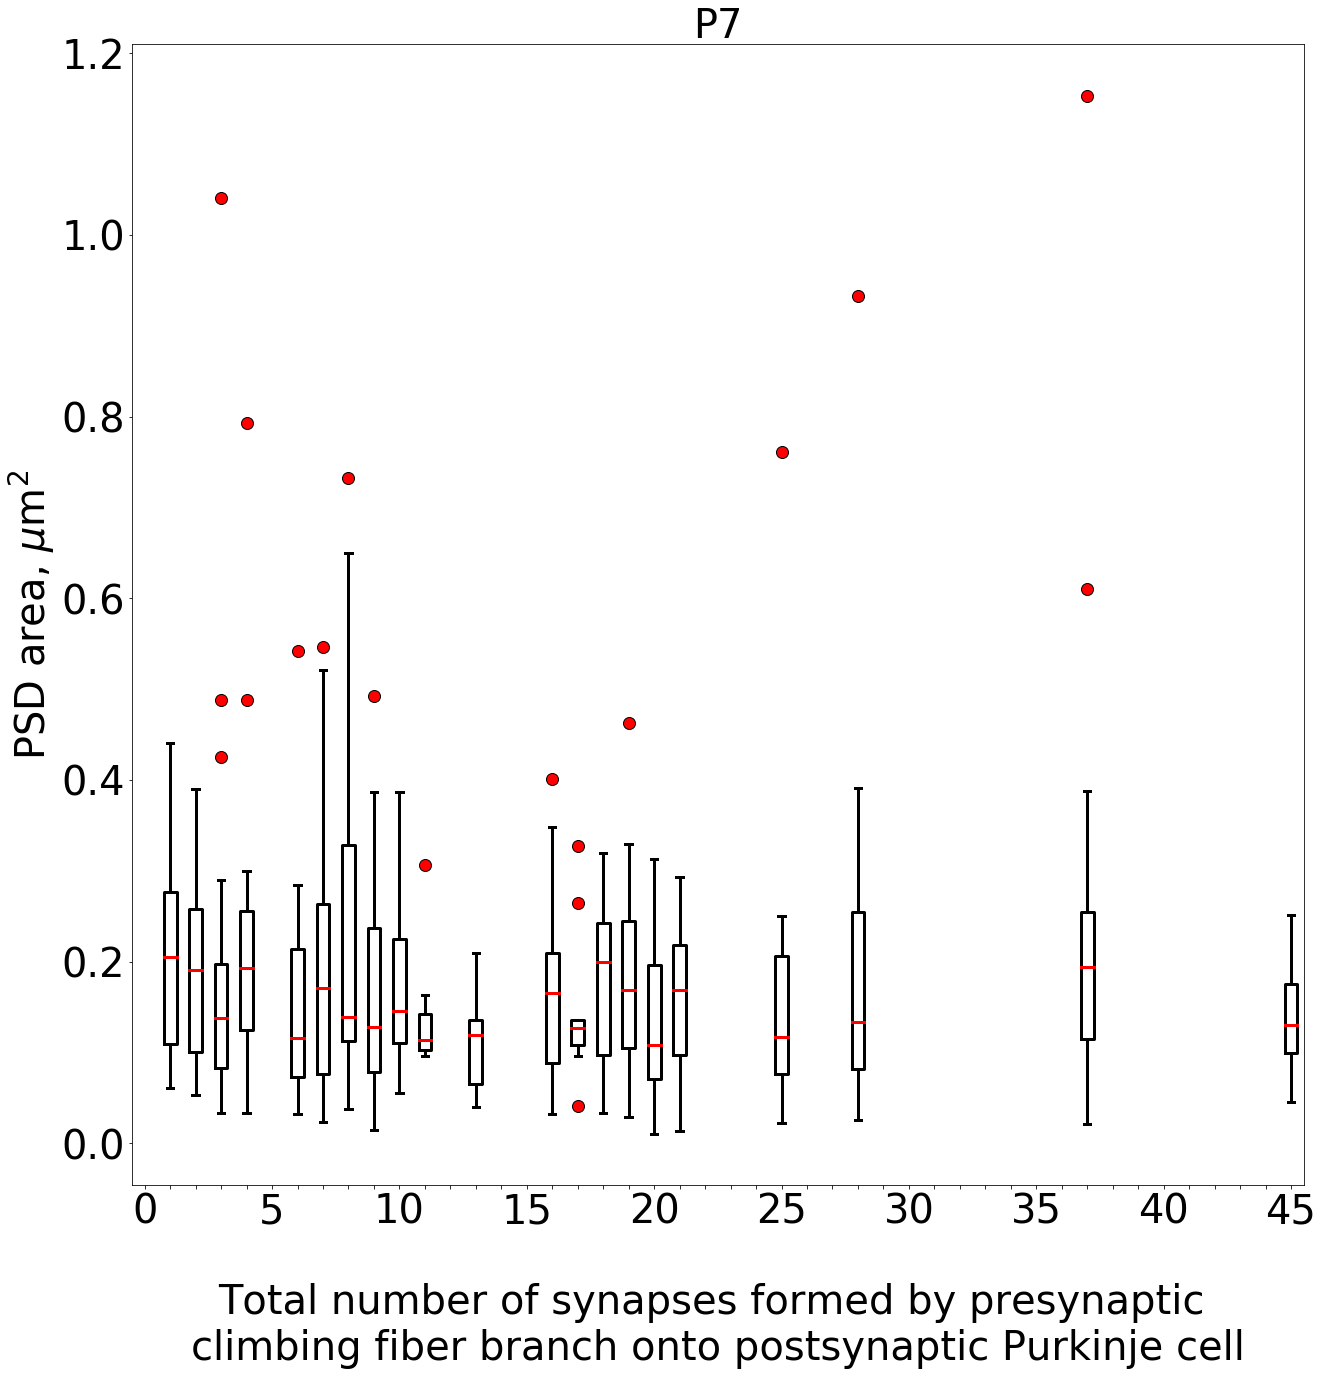

In [34]:
# p3
flierprops = dict(marker='o', markerfacecolor='r', markersize=12,linestyle='None', markeredgecolor='k')
medianprops = dict(linewidth='3.0',color='r')
whiskerprops = dict(linewidth='3.0',color='k')
boxprops = dict(linewidth='3.0',color='k')
capprops = dict(linewidth='3.0',color='k')
plt.figure(figsize=(21,21))
# plt.plot(p3_conn_sizes,areas_P3,'.',markersize=20)
plt.boxplot(p3_psd_areas_per_sz,labels=[str(q) for q in p3_conn_sz_to_plot],flierprops=flierprops,medianprops=medianprops,whiskerprops=whiskerprops,boxprops=boxprops,capprops=capprops) # alternative: show as a box plot
plt.xlabel('\nTotal number of synapses formed by presynaptic \nclimbing fiber branch onto postsynaptic Purkinje cell',fontsize=FS)
plt.ylabel('PSD area, $\mu$m$^2$',fontsize=FS)
plt.title('P3',fontsize=FS)
plt.tick_params(labelsize=FS)
# p3acs_fname = './data/figures/psds/190213_p3_psd_area_vs_tot_conn_size.png'
p3acs_fname = './data/figures/psds/190213_p3_psd_area_vs_tot_conn_size_bp.png' # for a box plot
# plt.show()
plt.savefig(p3acs_fname)
# p7
plt.figure(figsize=(21,21))
# plt.plot(p7_conn_sizes,areas_P7,'.',markersize=20)
plt.boxplot(p7_psd_areas_per_sz,labels=p7_conn_sz_to_plot,flierprops=flierprops,medianprops=medianprops,whiskerprops=whiskerprops,boxprops=boxprops,capprops=capprops) # alternative: show as a box plot
plt.xlabel('\nTotal number of synapses formed by presynaptic \nclimbing fiber branch onto postsynaptic Purkinje cell',fontsize=FS)
plt.ylabel('PSD area, $\mu$m$^2$',fontsize=FS)
plt.title('P7',fontsize=FS)
plt.tick_params(labelsize=FS)
# p7acs_fname = './data/figures/psds/190213_p7_psd_area_vs_tot_conn_size.png'
p7acs_fname = './data/figures/psds/190213_p7_psd_area_vs_tot_conn_size_bp.png' # for a box plot
# plt.show()
plt.savefig(p7acs_fname)

Compute Pearson's r for PSD areas and connection sizes

In [22]:
# p3
p3_obs_r,p3pval = pearsonr(p3_conn_sizes,areas_P3)
# p7
p7_obs_r,p7pval = pearsonr(p7_conn_sizes,areas_P7)
print(p3_obs_r,p7_obs_r) # debugging

0.03900747286122332 -0.020347279518114027


Permute PSD areas among all synapses and re-compute Pearson's r to determine whether the correlations we measured above are  consistent with random synapse areas per climbing fiber branch-Purkinje cell pair

In [23]:
# Set permutation test parameters
nrandseq = 100000

In [24]:
p3_mc_rs = []
p7_mc_rs = []

for q in range(nrandseq):
    areas_p3_permcurr = permutation(areas_P3)
    areas_p7_permcurr = permutation(areas_P7)
    p3_mc_rs.append(pearsonr(p3_conn_sizes,areas_p3_permcurr)[0])
    p7_mc_rs.append(pearsonr(p7_conn_sizes,areas_p7_permcurr)[0])


Plot results

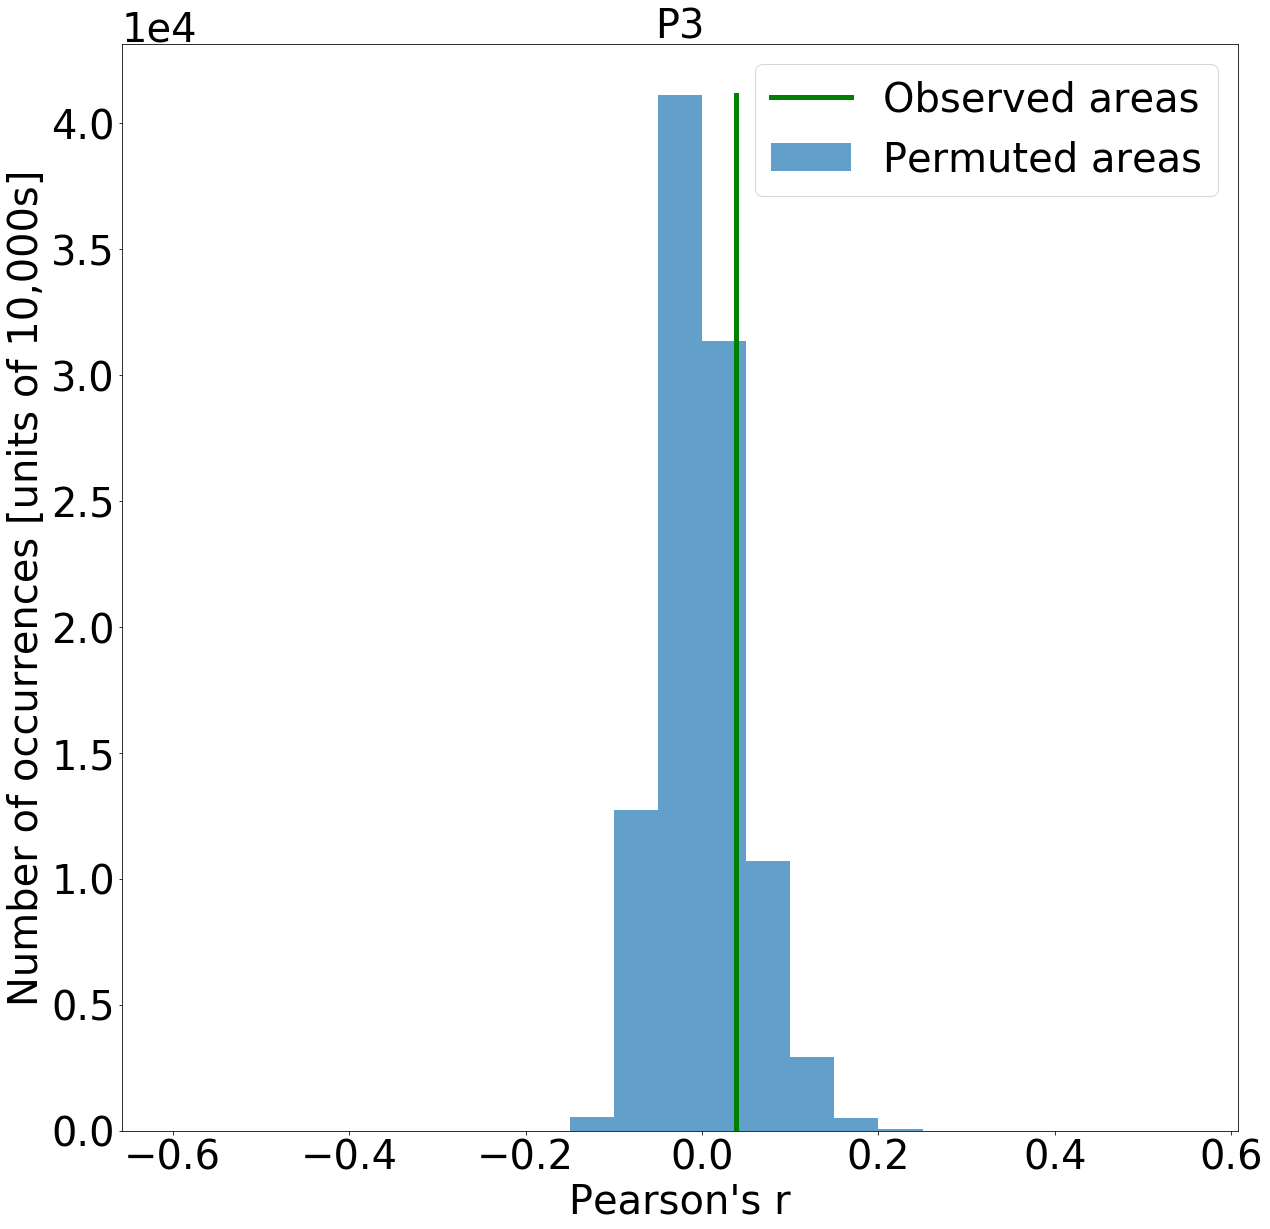

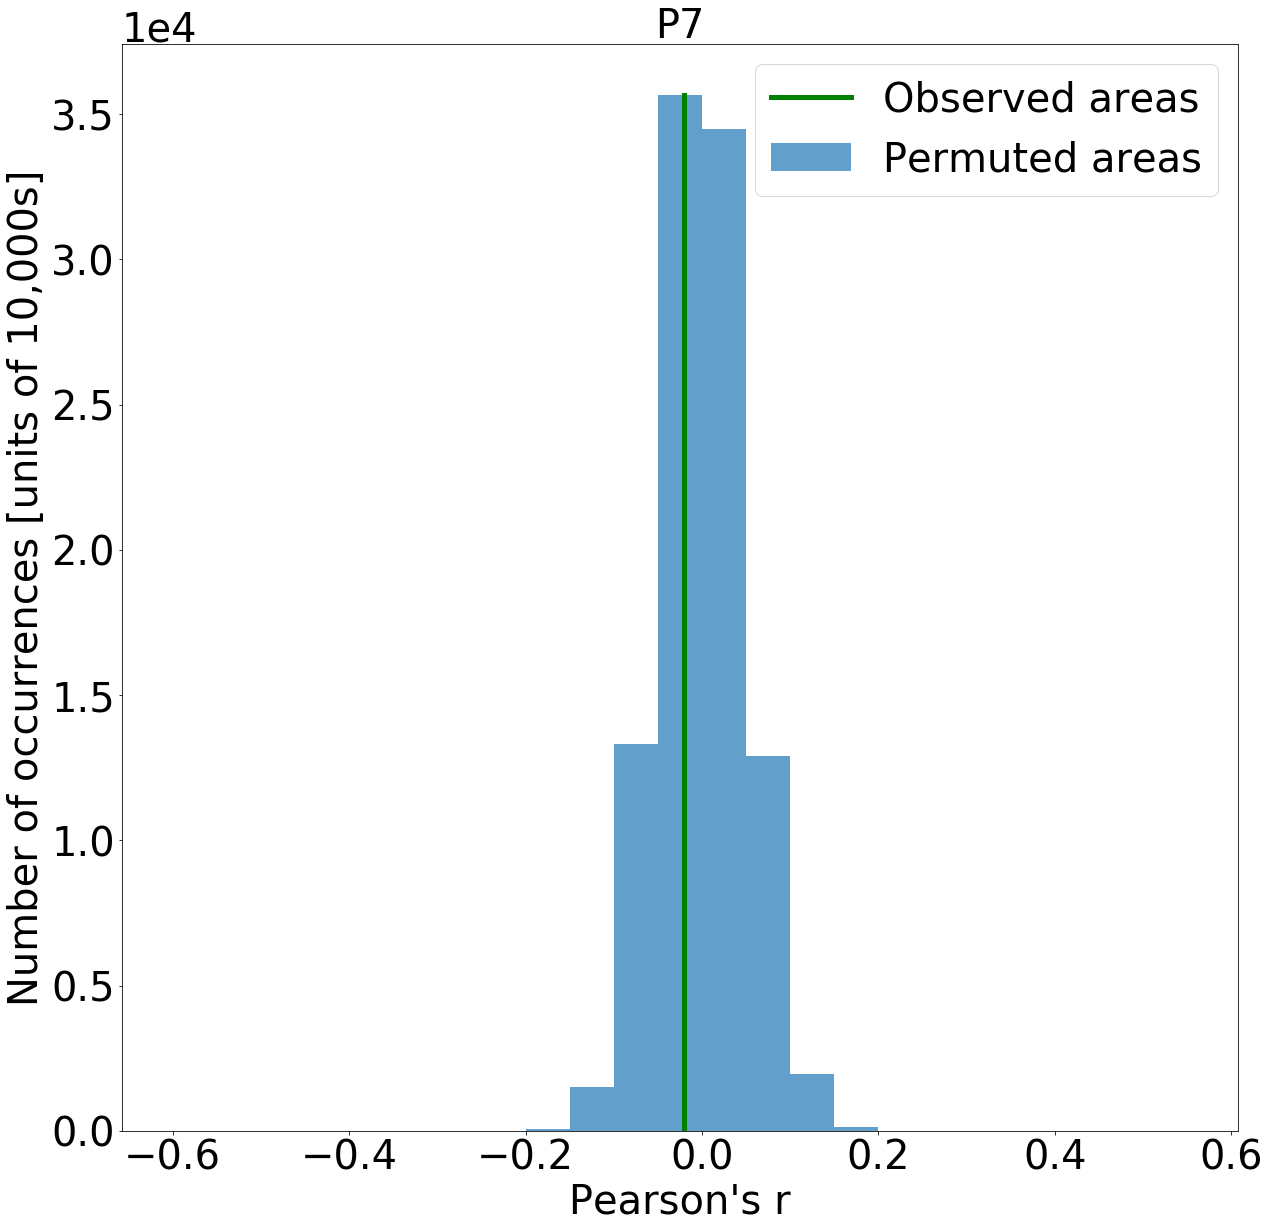

In [25]:
edges_pr_comp = np.arange(-60,60,5)*0.01

# p3
plt.figure(figsize=(20,20))
ax=plt.subplot()
p3h = plt.hist(p3_mc_rs,bins=edges_pr_comp,alpha=0.7,label='Permuted areas')
plt.plot([p3_obs_r,p3_obs_r],[0,np.max(p3h[0])+0.1],'g',linewidth=5,label='Observed areas')
plt.xlabel('Pearson\'s r',fontsize=FS)
plt.ylabel('Number of occurrences [units of 10,000s]',fontsize=FS)
plt.legend(loc='best',fontsize=FS)
# plt.title('P3, Correlations in PSD area and total number of synapses \n shared by presynaptic cf and postsynaptic PC',fontsize=FS)
plt.title('P3',fontsize=FS)
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.tick_params(labelsize=FS)
ax.yaxis.get_offset_text().set_fontsize(FS)
p3_perm_fname = './data/figures/psds/190213_p3_obs_vs_perm_test_corrs_niter_10000.png'
# plt.show()
plt.savefig(p3_perm_fname)
# p7
plt.figure(figsize=(20,20))
ax=plt.subplot()
p7h = plt.hist(p7_mc_rs,bins=edges_pr_comp,alpha=0.7,label='Permuted areas')
plt.plot([p7_obs_r,p7_obs_r],[0,np.max(p7h[0])+0.1],'g',linewidth=5,label='Observed areas')
plt.xlabel('Pearson\'s r',fontsize=FS)
plt.ylabel('Number of occurrences [units of 10,000s]',fontsize=FS)
plt.legend(loc='best',fontsize=FS)
# plt.title('P7, Correlations in PSD area and total number of synapses \n shared by presynaptic cf and postsynaptic PC',fontsize=FS)
plt.title('P7',fontsize=FS)
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.tick_params(labelsize=FS)
ax.yaxis.get_offset_text().set_fontsize(FS)
p7_perm_fname = './data/figures/psds/190213_p7_obs_vs_perm_test_corrs_niter_10000.png'
# plt.show()
plt.savefig(p7_perm_fname)

In [26]:
# Save results of permutation test along with observed PSD areas for each age
p3_obs_vs_perm_psd_corrs_dict = {
                                    'connection_sizes':[int(q) for q in p3_conn_sizes], \
                                    'areas_obs':areas_P3, \
                                    'niter':nrandseq, \
                                    'pearsonr_obs':p3_obs_r, \
                                    'pearsonrs_perm':p3_mc_rs \
                                }
p7_obs_vs_perm_psd_corrs_dict = {
                                    'connection_sizes':[int(q) for q in p7_conn_sizes], \
                                    'areas_obs':areas_P7, \
                                    'niter':nrandseq, \
                                    'pearsonr_obs':p7_obs_r, \
                                    'pearsonrs_perm':p7_mc_rs \
                                }

p3psdfname = './data/psd_conn_patterns/190211_p3_psd_area_and_conn_size_dist_and_perm_test_info.json'
p7psdfname = './data/psd_conn_patterns/190211_p7_psd_area_and_conn_size_dist_and_perm_test_info.json'

with open(p3psdfname,'w') as f:
    jsonobj = json.dumps(p3_obs_vs_perm_psd_corrs_dict)
    f.write(jsonobj)
with open(p7psdfname,'w') as f:
    jsonobj = json.dumps(p7_obs_vs_perm_psd_corrs_dict)
    f.write(jsonobj)

Compute two-tailed p-values for these distributions

In [27]:
# p3
mu_p3_mc_rs = np.mean(p3_mc_rs)
diff_obs_p3 = np.abs(p3_obs_r- mu_p3_mc_rs)
p3_ul = mu_p3_mc_rs + diff_obs_p3
p3_ll = mu_p3_mc_rs - diff_obs_p3
p3_frac_more_extreme = 1 - (len([q for q in p3_mc_rs if ((q < p3_ul) and (q > p3_ll))])/len(p3_mc_rs))
print(p3_frac_more_extreme)
# p7
mu_p7_mc_rs = np.mean(p7_mc_rs)
diff_obs_p7 = np.abs(p7_obs_r- mu_p7_mc_rs)
p7_ul = mu_p7_mc_rs + diff_obs_p7
p7_ll = mu_p7_mc_rs - diff_obs_p7
p7_frac_more_extreme = 1 - (len([q for q in p7_mc_rs if ((q < p7_ul) and (q > p7_ll))])/len(p7_mc_rs))
print(p7_frac_more_extreme)

0.3953
0.67206
